In [8]:
import pypower

In [9]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from case2b import case2b 

In [11]:
cl = case2b()

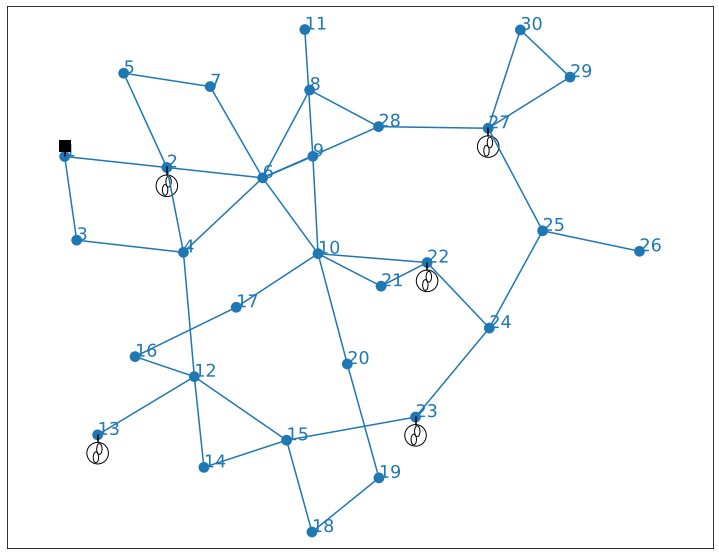

In [12]:
cl.draw_ppn_net()

In [13]:
cl.prepare_case()

In [14]:
cl.runopf_case()

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 2.03 seconds
Objective Function Value = 259666.90 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -140.0 to 405.9
Generators         9     On-line Capacity       335.0        -140.0 to 405.9
Committed Gens     9     Generation (actual)    150.8              89.6
Loads             17     Load                   147.6              91.9
  Fixed           17       Fixed                147.6              91.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)      

In [15]:
cl.get_price_formings()

Price forming bus #2	 C_g=1000.000000
Price forming bus #22	 C_g=1000.000000
Price forming bus #27	 C_g=1500.000000
Price forming bus #23	 C_g=5000.000000
Price forming bus #13	 C_g=10000.000000


[1, 21, 26, 22, 12]

In [21]:
pd.DataFrame(cl.ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,1500.0,0.0
1,2.0,0.0,0.0,2.0,1000.0,0.0
2,2.0,0.0,0.0,2.0,1000.0,0.0
3,2.0,0.0,0.0,2.0,1500.0,0.0
4,2.0,0.0,0.0,2.0,5000.0,0.0
5,2.0,0.0,0.0,2.0,10000.0,0.0
6,2.0,0.0,0.0,2.0,-42000.0,0.0
7,2.0,0.0,0.0,2.0,-42000.0,0.0
8,2.0,0.0,0.0,2.0,-42000.0,0.0


In [22]:
cl.solve()


#Var = 199
#Eq = 60
Underdetermined:  True
x:
lam_p, |lam_p| = 27
lam_q, |lam_q| = 30
sigma, |sigma| = 82
mu, |mu| = 60
f(x^*) = 7.595036779738341e-10


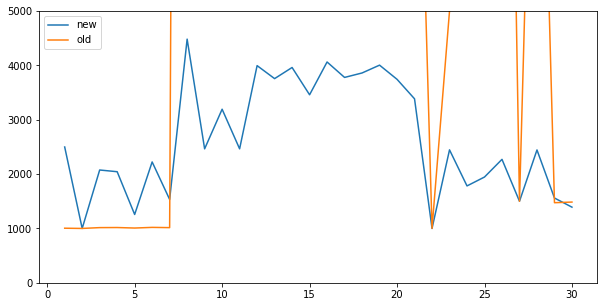

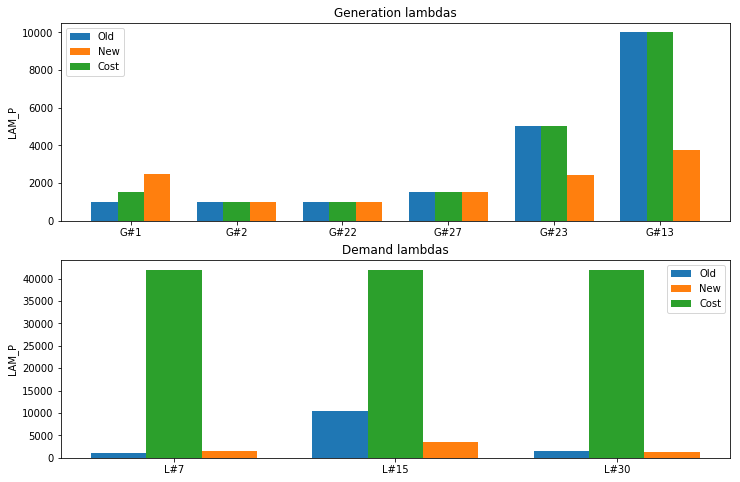

In [23]:
cl.plot(0, 5000)

In [3]:
from pypower.api import case30pwl, case30Q 
from pypower.api import case30, ppoption, runpf, printpf, runopf, case24_ieee_rts, case14, case9
from pypower.loadcase import loadcase

#from drawings import *
from utils import *
from pypower.api import opf_consfcn, opf_costfcn
from pypower.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
from scipy.optimize import minimize, nnls, linprog

In [4]:
bus_cols, gen_cols, brch_cols, cost_cols = get_cols()

In [5]:
ppc = case30()
#ppopt = ppoption(PF_ALG=2)
ppopt = ppoption(PF_ALG=1, RETURN_RAW_DER=True, OPF_FLOW_LIM=1)

In [6]:
from pandapower.plotting.plotly import simple_plotly
import pandapower.networks as pn
from pandapower import runpp
net = pn.case30()
runpp(net)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



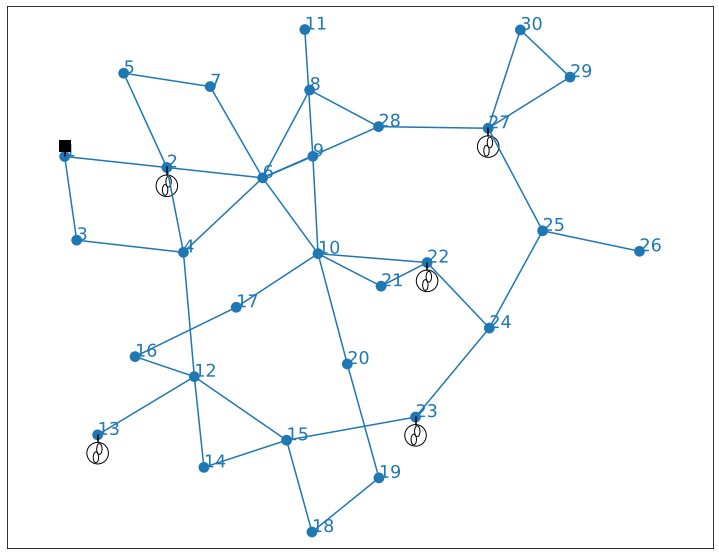

In [7]:
from drawings import *
draw_net(net)

In [8]:
gens = ppc['gen'][:, 0]

load_list = []

for bus_str in ppc['bus']:
    tmp = np.zeros(21)
    if bus_str[0] in [7., 15., 30.]:
        if bus_str[0] not in gens:
            #print('load #%d' % bus_str[0])
            tmp[0] = bus_str[0]

            tmp[1] = -30.#bus_str[2]
            tmp[2] = -15.#bus_str[3]

            tmp[3] = -0.0001
            tmp[4] = -15.

            tmp[5] = bus_str[7]
            tmp[6] = 100.

            tmp[7] = 1.

            #fixed here
            tmp[8] = -0.0001
            tmp[9] = -30.

            bus_str[2], bus_str[3] = 0., 0.
            load_list.append(tmp)

ppc['gen'] = np.concatenate((ppc['gen'], np.array(load_list)))

In [9]:
from pypower.idx_bus import PD, QD, VM, VA, GS, BUS_TYPE, PQ, REF
from pypower.idx_brch import PF, PT, QF, QT
from pypower.idx_gen import PG, QG, VG, QMAX, QMIN, GEN_BUS, GEN_STATUS
from numpy import r_, c_, ix_, zeros, pi, ones, exp, argmax
from pypower.ext2int import ext2int

In [10]:
alpha = 1.0
#bound max flow 3 <-> 11
ppc['branch'][14][5] *= alpha
#bound max flow 9 <-> 16
ppc['branch'][25][5] *= alpha
#bound max flow 27 <-> 26
#ppc['branch'][35][5] *= alpha
#bound max flow 18 <-> 19
#ppc['branch'][23][5] *= alpha
#bound max flow 22 <-> 23
ppc['branch'][31][5] *= alpha
ppc['branch'][14][2] = 10000000*alpha
ppc['branch'][14][5] = 0*alpha

In [11]:
ppc['gencost'][:,3] = np.ones(ppc['gencost'].shape[0]) * 2
ppc['gencost'] = ppc['gencost'][:,[0,1,2,3,5,6]]
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0


In [12]:
cost_list = []

for load in load_list:
    cost_list.append(np.array([2., 0., 0., 2., -10., 0]))
    
ppc['gencost'] = np.concatenate((ppc['gencost'], np.array(cost_list)))

In [14]:
#alpha = 1.0

ppc['branch'][9][5] *= .5
ppc['branch'][23][5] *= .5
ppc['branch'][30][5] *= .5
ppc['branch'][33][5] *= .5
ppc['branch'][39][5] *= 5
ppc['branch'][9][5] *= 2

#pd.DataFrame(ppc['branch'], columns = brch_cols)

In [15]:
ppc['gencost'][:,4][: 6] = 400
ppc['gencost'][:,4][6: ] = -10
ppc['gencost'][:,4][-2: ] = -10

ppc['gencost'][0, 4] = 15.
ppc['gencost'][1, 4] = 10.
ppc['gencost'][2, 4] = 10.
ppc['gencost'][3, 4] = 15.
ppc['gencost'][4, 4] = 50.
ppc['gencost'][5, 4] = 100. #generator on bus 13
ppc['gencost'][:,4:] *= 100.
ppc['gencost'][6:,4] = -42000
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,1500.0,0.0
1,2.0,0.0,0.0,2.0,1000.0,0.0
2,2.0,0.0,0.0,2.0,1000.0,0.0
3,2.0,0.0,0.0,2.0,1500.0,0.0
4,2.0,0.0,0.0,2.0,5000.0,0.0
5,2.0,0.0,0.0,2.0,10000.0,0.0
6,2.0,0.0,0.0,2.0,-42000.0,0.0
7,2.0,0.0,0.0,2.0,-42000.0,0.0
8,2.0,0.0,0.0,2.0,-42000.0,0.0


In [16]:
results = runopf(ppc, ppopt)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 1.46 seconds
Objective Function Value = 282130.71 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -140.0 to 405.9
Generators         9     On-line Capacity       335.0        -140.0 to 405.9
Committed Gens     9     Generation (actual)    150.1              88.2
Loads             17     Load                   147.6              91.9
  Fixed           17       Fixed                147.6              91.9
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)      

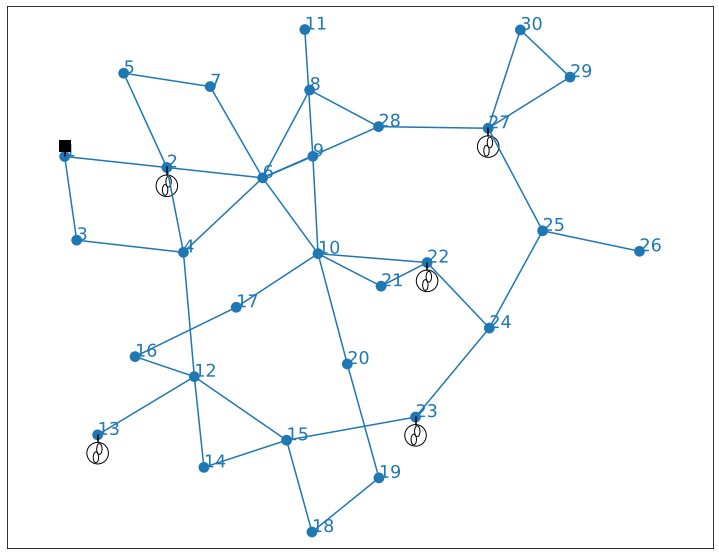

In [17]:
draw_net(net)

In [18]:
is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #2	 C_g=1000.000000
Price forming bus #22	 C_g=1000.000000
Price forming bus #27	 C_g=1500.000000
Price forming bus #23	 C_g=5000.000000
Price forming bus #13	 C_g=10000.000000


[1, 21, 26, 22, 12]

In [19]:
from solution_options import set_options, set_alg, check_opt_alg, set_idx_mode

sol_opt = set_options()
alg = set_alg()
idx_mode = set_idx_mode()
alg = check_opt_alg(sol_opt, alg)

threshold=2000

# 0 1 ... 2 3 1

BoundedLS not for mode = 1


In [20]:
import utils
dgT, dgeqT = utils.get_Jac(ppc, ppopt, results)
utils.is_price_forming(results['gen'], results['gencost'], verbose=True)


Price forming bus #2	 C_g=1000.000000
Price forming bus #22	 C_g=1000.000000
Price forming bus #27	 C_g=1500.000000
Price forming bus #23	 C_g=5000.000000
Price forming bus #13	 C_g=10000.000000


[1, 21, 26, 22, 12]

In [21]:
from solver import *
from utils import Rand_replace, Median_func
res_struct = Solve(dgT, dgeqT, results, threshold, 
                   replace_func=Rand_replace, 
                   opt=sol_opt,
                   alg=alg, 
                   idx_mode=idx_mode,
                   alpha=0.2, beta=0.8)


#Var = 205
#Eq = 60
Underdetermined:  True
x:
lam_p, |lam_p| = 21
pi_max, |pi_max| = 3
pi_min, |pi_min| = 3
psi_max, |psi_max| = 3
psi_min, |psi_min| = 3
lam_q, |lam_q| = 30
sigma, |sigma| = 82
mu, |mu| = 60
f(x^*) = 2.3038619385491503e-09


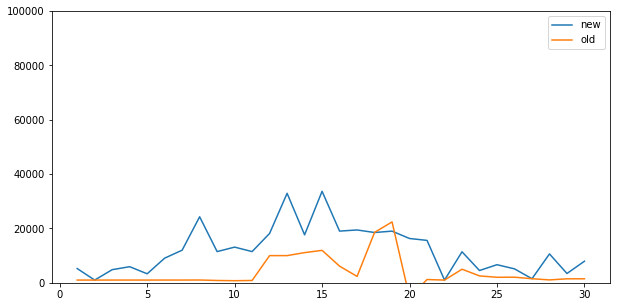

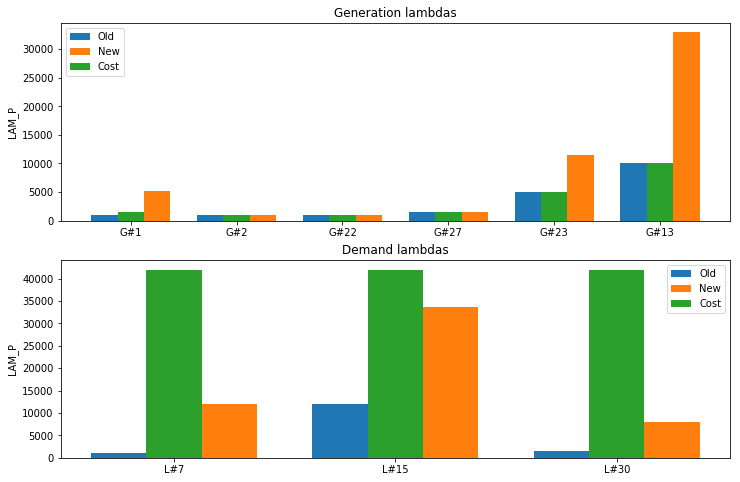

In [25]:
from drawings import draw_nice_hists, draw_nasty_profile
draw_nasty_profile(results, (0, 100000))
draw_nice_hists(gens, results)

In [ ]:
pd.DataFrame(results['bus'], columns=bus_cols)

#pd.DataFrame(ppc['bus'], columns = bus_cols)

In [ ]:
pd.DataFrame(results['gen'], columns=gen_cols)

In [ ]:
pd.DataFrame(ppc['bus'], columns=bus_cols)

In [ ]:
help(pypower)

In [1]:
from case2b import case2b